#### 1. Load in data

In [1]:
# load libraries
import os
import shutil
import tarfile
import urllib.request
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf

In [2]:
import platform

# Check operating system
is_macos = platform.system() == 'Darwin'

if is_macos:
    # For MacOS, use TensorFlow backend
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    import tensorflow as tf
    print("Using TensorFlow backend on MacOS")
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
else:
    # For other OS, use PyTorch backend
    os.environ['KERAS_BACKEND'] = 'torch'
    import torch
    print("Using PyTorch backend")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [3]:
# download data from tensorflow
DATA_DIR = "../data"
os.makedirs(DATA_DIR, exist_ok=True)

# URLs
IMAGES_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
ANNOT_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"

IMAGE_TAR_PATH = os.path.join(DATA_DIR, "images.tar")
ANNOT_TAR_PATH = os.path.join(DATA_DIR, "annotation.tar")

def download(url, path):
    if os.path.exists(path):
        print(f"{path} already exists, skipping download.")
        return
    print(f"Downloading {url} ...")
    urllib.request.urlretrieve(url, path)
    print("Done!")

download(IMAGES_URL, IMAGE_TAR_PATH)
download(ANNOT_URL, ANNOT_TAR_PATH)

Done!
Done!


In [4]:
# extract
def extract(tar_path, extract_to):
    print(f"Extracting {tar_path} ...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(extract_to)
    print("Done!")

extract(IMAGE_TAR_PATH, DATA_DIR)
extract(ANNOT_TAR_PATH, DATA_DIR)

Extracting ../data/images.tar ...


/tmp/ipython-input-280388653.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_to)


Done!
Extracting ../data/annotation.tar ...
Done!


In [5]:
# ensure clean directory structure
IMAGES_ROOT = os.path.join(DATA_DIR, "Images")

# Verify structure
print("Number of breeds:", len(os.listdir(IMAGES_ROOT)))

Number of breeds: 120


#### 2. Conduct Data Splits

In [6]:
OUTPUT_DIR = os.path.join(DATA_DIR, "data_splits")
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_dir = os.path.join(OUTPUT_DIR, "train")
val_dir = os.path.join(OUTPUT_DIR, "val")
test_dir = os.path.join(OUTPUT_DIR, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

breeds = os.listdir(IMAGES_ROOT)

for breed in tqdm(breeds, desc="Splitting breeds"):
    full_path = os.path.join(IMAGES_ROOT, breed)
    images = [os.path.join(full_path, f) for f in os.listdir(full_path)]

    # Split
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Create output folders
    for split_name, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_folder = os.path.join(OUTPUT_DIR, split_name, breed)
        os.makedirs(split_folder, exist_ok=True)

        # Copy images
        for img in split_imgs:
            shutil.copy(img, split_folder)


Splitting breeds: 100%|██████████| 120/120 [00:02<00:00, 54.35it/s]


#### 3. Convert to TF Dataset for efficiency

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)


Found 14357 files belonging to 120 classes.
Found 3082 files belonging to 120 classes.
Found 3141 files belonging to 120 classes.


#### 4. Cleaning/Augmentation with Keras

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), # normalize pixel values
    tf.keras.layers.RandomFlip("horizontal"), # random horizontal flip
    tf.keras.layers.RandomRotation(0.1), # random rotations up to 0.10 degrees
    tf.keras.layers.RandomZoom(0.1) #random zoom in/out by 90-110%
])

# train gets all the augmentations
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Validation & test only get normalization
norm = tf.keras.layers.Rescaling(1./255)
val_ds = val_ds.map(lambda x, y: (norm(x), y))
test_ds = test_ds.map(lambda x, y: (norm(x), y))

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

#### 5. Build CNN Structure

In [10]:
from tensorflow.keras import layers, optimizers

def cnn_base_model():
    # using sequential
    model = tf.keras.Sequential([

        # creating first convolutional block
        # first convolution layer
        layers.Conv2D(32, (3,3), padding='same', input_shape=(224,224,3)),
        # then BatchNormalization - to normalize the activations of each layer
        layers.BatchNormalization(),
        # Maxpooling - to reduce spatial zsize by taking max value in each window
        layers.MaxPooling2D(2,2),

        # second convolution block
        layers.Conv2D(64, (3,3), padding='same'), # similar set up as prev block
        # add BatchNormalization
        layers.BatchNormalization(),
        # max pooling
        layers.MaxPooling2D(2,2),

        # third convolution block
        layers.Conv2D(128, (3,3), padding='same'), # similar as above
        # add BatchNormalization
        layers.BatchNormalization(),
        # add max pooling
        layers.MaxPooling2D(2,2),

        # now to add dense layer

        # first need to flatten
        layers.Flatten(),

        # one dense layer
        layers.Dense(128),
        # add batch normalization
        layers.BatchNormalization(),
        # add a dropout layer
        layers.Dropout(0.4),

        # need the output layer for 120 classes (breeds of dogs)
        layers.Dense(120, activation='softmax')
    ])

    # to compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',  # use this bc integer class labels
        metrics=['accuracy']
    )

    # print summary of model
    model.summary()
    return model

model = cnn_base_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,955,320 (49.42 MB)

 Trainable params: 12,954,616 (49.42 MB)

 Non-trainable params: 704 (2.75 KB)

#### 6. Training

In [11]:
# early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[callback]
)


Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 178s 36ms/step - accuracy: 0.0186 - loss: 5.0880 - val_accuracy: 0.0396 - val_loss: 4.4605
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0466 - loss: 4.5007 - val_accuracy: 0.0480 - val_loss: 4.5312
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0876 - loss: 4.1744 - val_accuracy: 0.0474 - val_loss: 4.7170
Epoch 4/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1872 - loss: 3.6049 - val_accuracy: 0.0480 - val_loss: 4.7081
Epoch 5/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4280 - loss: 2.6580 - val_accuracy: 0.0409 - val_loss: 5.3574
Epoch 6/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7793 - loss: 1.2540 - val_accuracy: 0.0399 - val_loss: 6.1638


#### 7. Visualize Training Progress

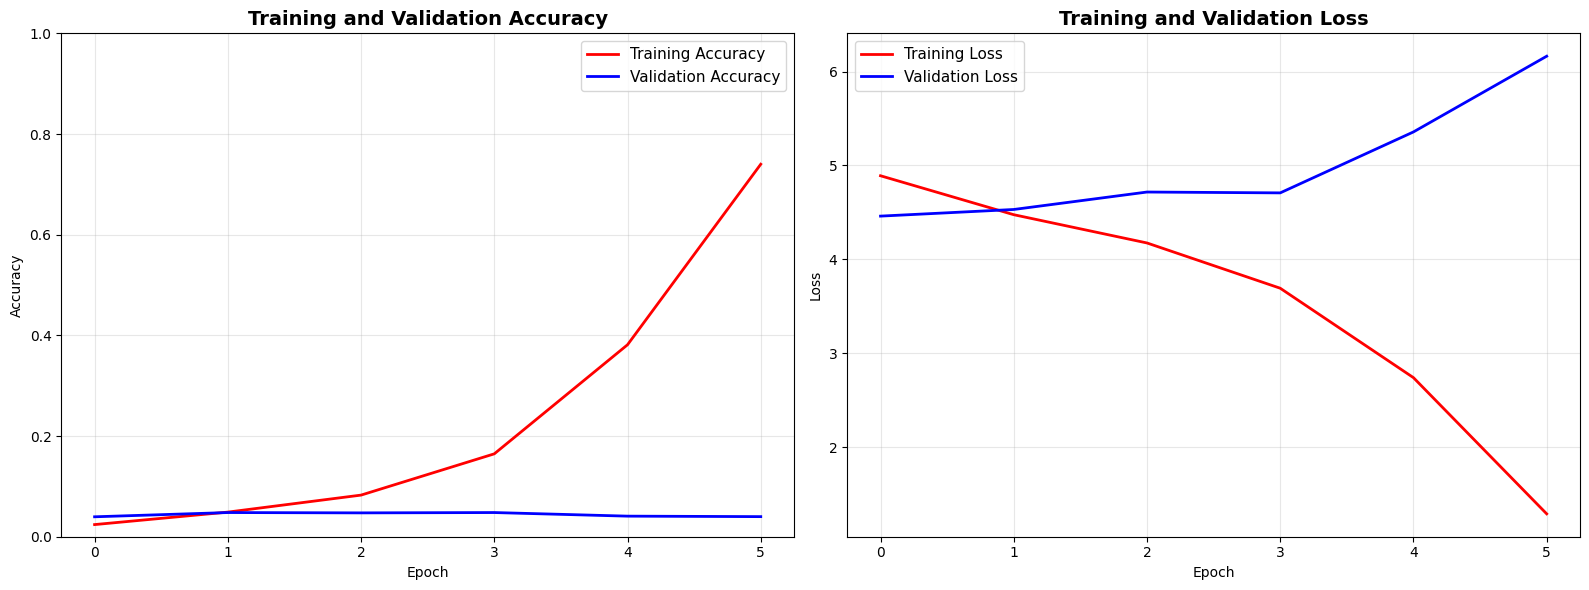


  Training Summary
  Best Training Accuracy:   0.7400
  Best Validation Accuracy: 0.0480
  Final Training Accuracy:  0.7400
  Final Validation Accuracy:0.0399
  Accuracy Gap (final):     0.7001


In [12]:
import matplotlib.pyplot as plt

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
ax1.legend(fontsize=11); ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Loss plot
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.legend(fontsize=11); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stats printout
print(f"\n{'='*60}")
print("  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f}")
print(f"  Best Validation Accuracy: {max(val_acc):.4f}")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

#### 8. Evaluation


Evaluating on test set...
Test Loss: 4.4747
Test Accuracy: 0.0446
Manual Test Accuracy: 0.0446


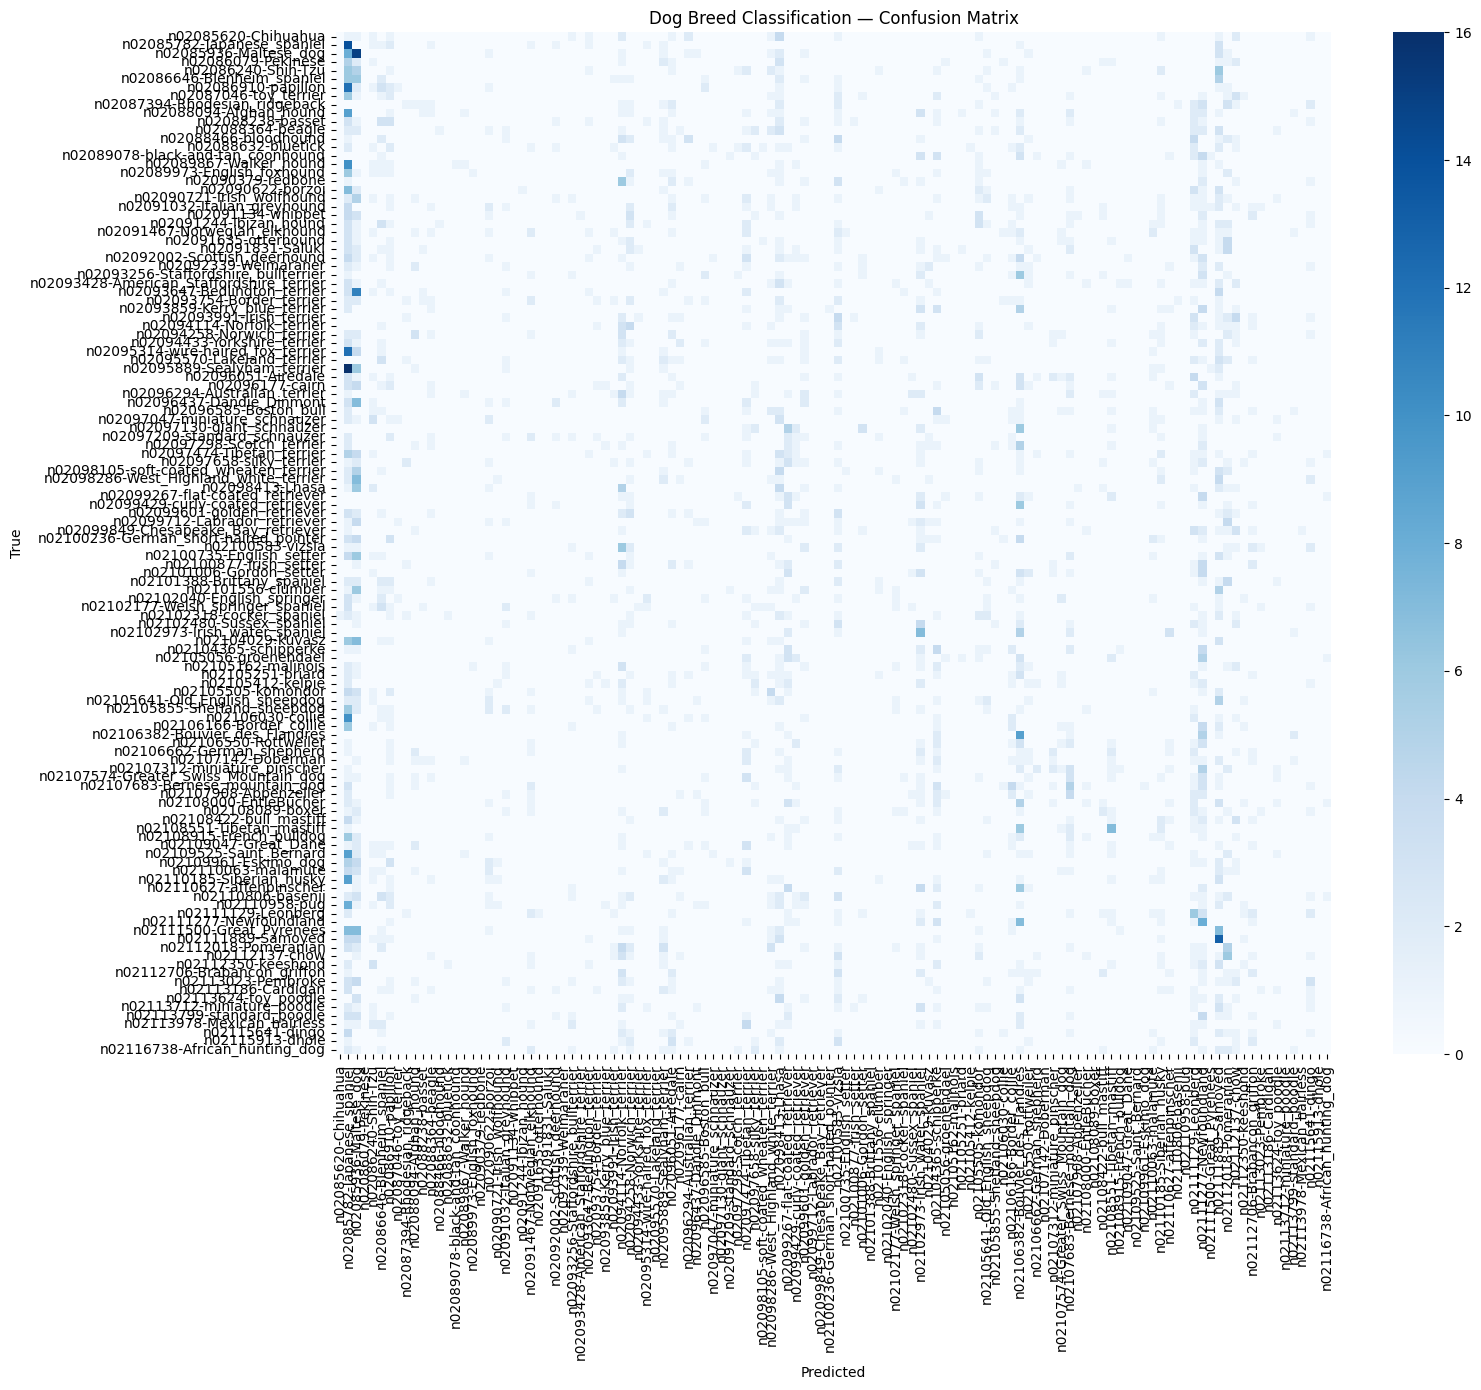

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Manual accuracy
accuracy = (y_pred == y_true).mean()
print(f"Manual Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# Retrieve class names directly from the training directory
class_names = sorted(os.listdir(train_dir))

plt.figure(figsize=(16, 14))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Dog Breed Classification — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()